In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [107]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['emoid'])
print(len(subs))

X = get_X(allts, ['emoid'], subs)
print(X[0].shape)

922
(922, 264, 210)


In [108]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [np.corrcoef(ts) for ts in filter_design_ts(X[0])]
p = np.stack(p)
print(p.shape)

(922, 264, 264)


/tmp/ipykernel_8332/4160920766.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


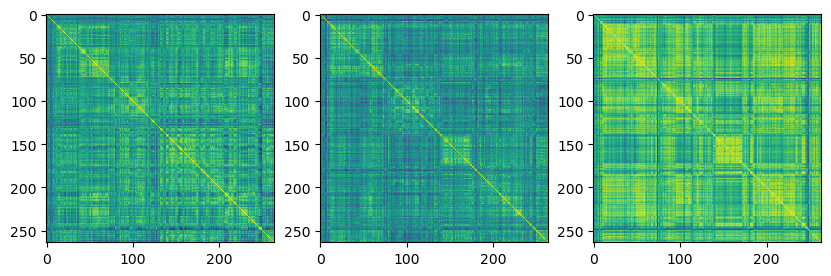

In [109]:
# Check pearson matrices

import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(p[10])
ax[1].imshow(p[58])
ax[2].imshow(p[90])
fig.show()

In [116]:
# Convert to torch

import torch
import torch.nn as nn
import torch.nn.functional as F

# Initial set size 20
# Subject 129 is a far outlier

# outliers = np.array([167, 405, 58, 129, 602])
outliers = np.array([141,429])
admit = np.setdiff1d(np.arange(p.shape[0]), outliers)
X_t = torch.from_numpy(p[admit]).float().cuda()

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

X_t = torch.stack([mask(X_t[i]) for i in range(X_t.shape[0])])

class LowRankFC(nn.Module):
    def __init__(self, ranks, ntrain):
        super(LowRankFC, self).__init__()
        self.codes = []
        for rank in ranks:
            code = nn.Parameter(1e-3*torch.randn(rank,264).float().cuda())
            self.codes.append(code)
        self.codes = nn.ParameterList(self.codes)
        self.w = nn.Parameter(torch.randn(ntrain,len(ranks)).float().cuda())
        
    def get_full_rank(self, test=False):
        full = []
        for low in self.codes:
            full.append(mask(low.T@low))
        return torch.stack(full)
        
    def forward(self, test=False):
        full = self.get_full_rank().unsqueeze(0)
        subfull = torch.einsum('nc,ncij->nij',self.w,full)
        return subfull
    
nEpochs = 4000
pPeriod = 400

lrfc = LowRankFC((1000*[1]),X_t.shape[0])
optim = torch.optim.Adam(lrfc.parameters(), lr=1e-2, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

mseLoss = nn.MSELoss()

for epoch in range(nEpochs):
    optim.zero_grad()
    subfull = lrfc()
    loss = mseLoss(subfull, X_t)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {[float(part) for part in [loss]]} lr: {sched._last_lr}')
        
print('Complete')

0 [0.14812196791172028] lr: [0.01]
400 [0.011999468319118023] lr: [0.0095]
800 [0.010779955424368382] lr: [0.007350918906249998]
1200 [0.010655260644853115] lr: [0.005688000922764597]
1600 [0.010060269385576248] lr: [0.0044012666865176535]
2000 [0.00988564919680357] lr: [0.0037735360253530726]
2400 [0.009743629023432732] lr: [0.0030735686772502355]
2800 [0.009634233079850674] lr: [0.0026352009446574203]
3200 [0.009540711529552937] lr: [0.0021463876394293723]
3600 [0.009460031054913998] lr: [0.0018402591023557579]
3999 [0.00939605850726366] lr: [0.001498902540488154]
Complete


[224 913 788 722 311]
[210 157 223  61 323]
[518 364 485 472 808]
[ 70 791 363 660 688]
[37.41237259 37.73569107 38.64551926 38.82034302 40.20859909]


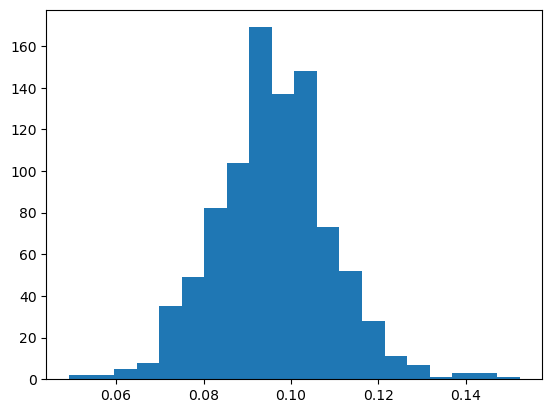

In [117]:
err = np.array([float(torch.dist(X_t[i], subfull[i])) for i in range(X_t.shape[0])])

idcs = np.argsort(err)
print(idcs[:5])
print(idcs[20:25])
print(idcs[100:105])
print(idcs[-5:])
print(err[idcs[-5:]])

plt.hist((err**2/264/264)**0.5, bins=20)
plt.show()
    

/tmp/ipykernel_8332/523494240.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


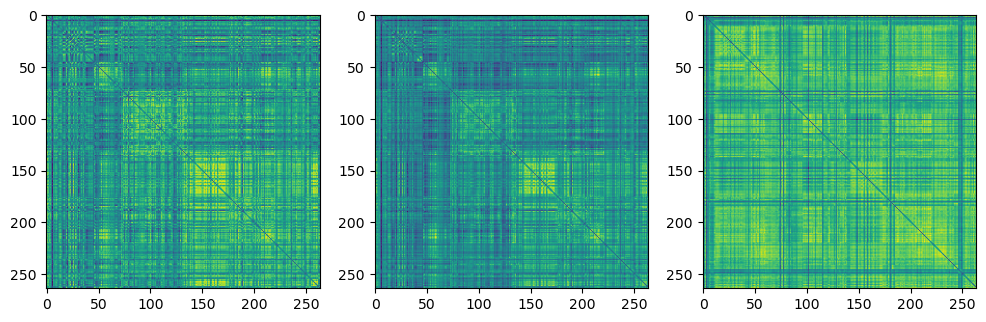

In [118]:
# Check pearson matrices

import matplotlib.pyplot as plt

rank = 10

U,S,Vh = torch.linalg.svd(X_t[0])
LR = U[:,:rank] @ torch.diag(S[:rank]) @ Vh[:rank]

fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].imshow(mask(LR).detach().cpu().numpy())
ax[1].imshow(subfull[0].detach().cpu().numpy())
ax[2].imshow(subfull[679].detach().cpu().numpy())

fig.show()

In [81]:
lmbda = S[:rank]**0.5

tensor([7.5545, 5.5650], device='cuda:0')

In [82]:
lrfc.w

Parameter containing:
tensor([[0.3466]], device='cuda:0', requires_grad=True)

In [84]:
lrfc.codes[0].shape

torch.Size([2, 264])

In [95]:
X_t.shape

torch.Size([870, 264, 264])